# Climate event detection task
Sandbox for preprocessing and first learning test

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys
sys.path.append('../..')

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs

In [3]:
import h5py
import matplotlib.patches as patches

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

List of parameters:
* TMQ: Total (vertically integrated) precipitatable water
* U850: Zonal wind at 850 mbar pressure surface
* V850: Meridional wind at 850 mbar pressure surface
* UBOT: Lowest model level zonal wind
* VBOT: Lowest model level meridional wind
* QREFHT: Reference height humidity
* PS: Surface pressure
* PSL: sea level pressure
* T200: temp at 200 mbar pressure surface
* T500: temp at 500 mbar pressure surface
* PRECT: Total (convective and large-scale) precipitation rate (liq + ice)
* TS: Surface temperature (radiative)
* Z100: Geopotential Z at 100 mbar pressure surface
* Z200: Geopotential Z at 200 mbar pressure surface
* ZBOT: Lowest model level height

resolution of 768 x 1152 equirectangular grid (25-km at equator)

The labels are 0 for background class, 1 for tropical cyclone, and 2 for atmoshperic river

In [5]:
path = '../../data/Climate/'

In [6]:
year, month, day, hour, run = 2106, 1, 1, 0, 1
datapath = '../../data/Climate/data_5_all/data-{}-{:0>2d}-{:0>2d}-{:0>2d}-{}-mesh.npz'.format(year, month, day, hour, run)

In [7]:
plop = np.load(datapath)
data = plop["data"]
labels = plop["labels"]

In [8]:
data.shape

(16, 10242)

In [5]:
stats = h5py.File('../../data/Climate/stats.h5')
stats = stats['climate']["stats"] # (16 X 4) (mean, max, min, std)

In [84]:
year, month, day, hour, run = 2106, 1, 1, 0, 1
datapath = '../../data/Climate/data-{}-{:0>2d}-{:0>2d}-{:0>2d}-{}.h5'.format(year, month, day, hour, run)

In [85]:
h5f = h5py.File(datapath)
data = h5f['climate']["data"] # (16,768,1152) numpy array
labels = h5f['climate']["labels"] # (768,1152) numpy array

In [9]:
lon_ = np.arange(1152)/1152*360
lat_ = np.arange(768)/768*180-90
lon, lat = np.meshgrid(lon_, lat_)

In [6]:
from deepsphere.utils import icosahedron_graph

In [7]:
g = icosahedron_graph(5)

In [8]:
icolong, icolat = np.rad2deg(g.long), np.rad2deg(g.lat)

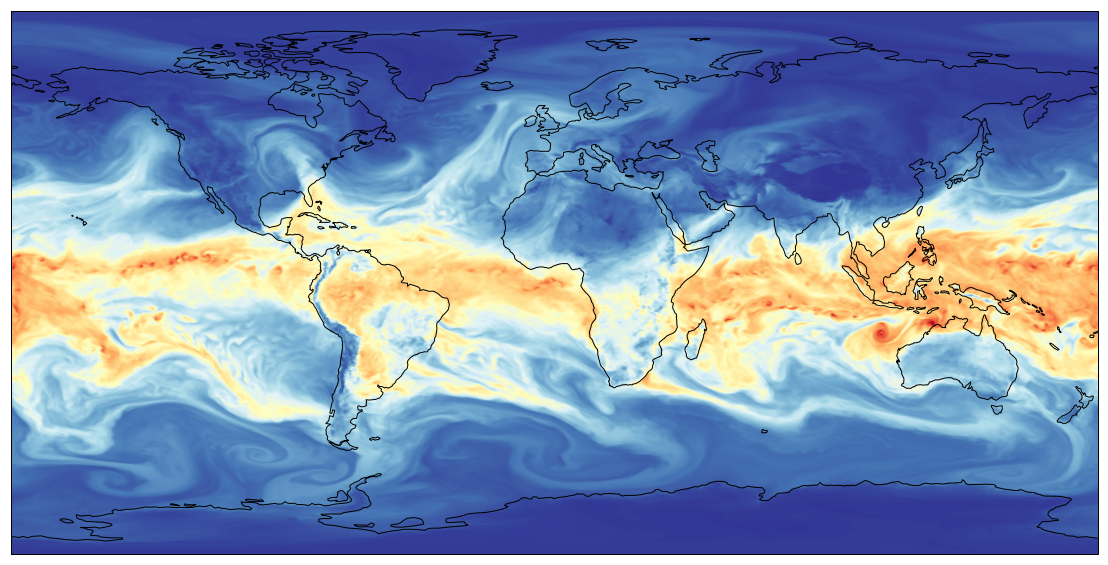

In [87]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=data[0,:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

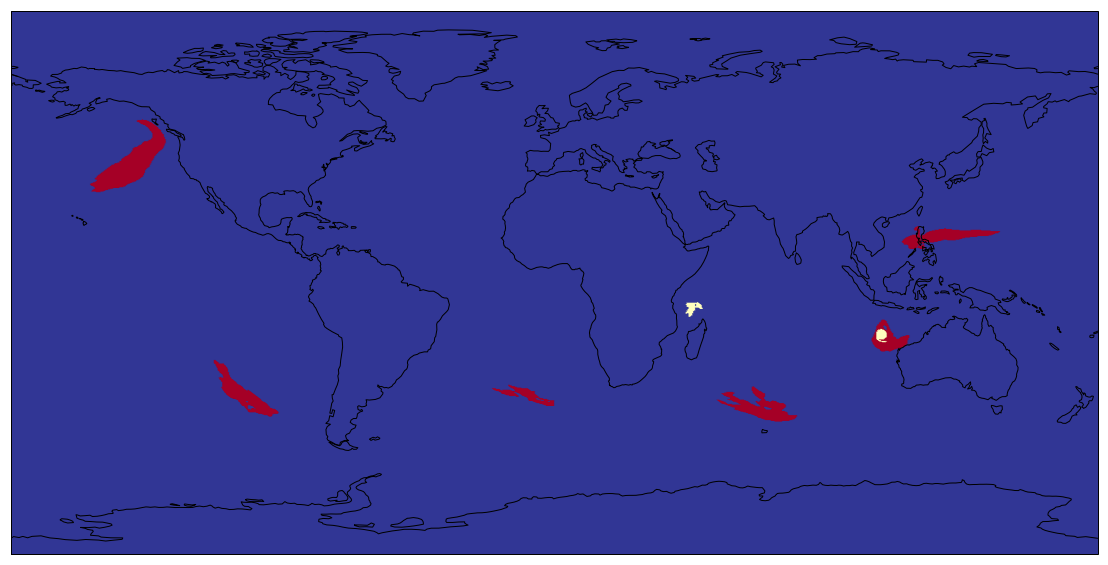

In [88]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=labels[:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

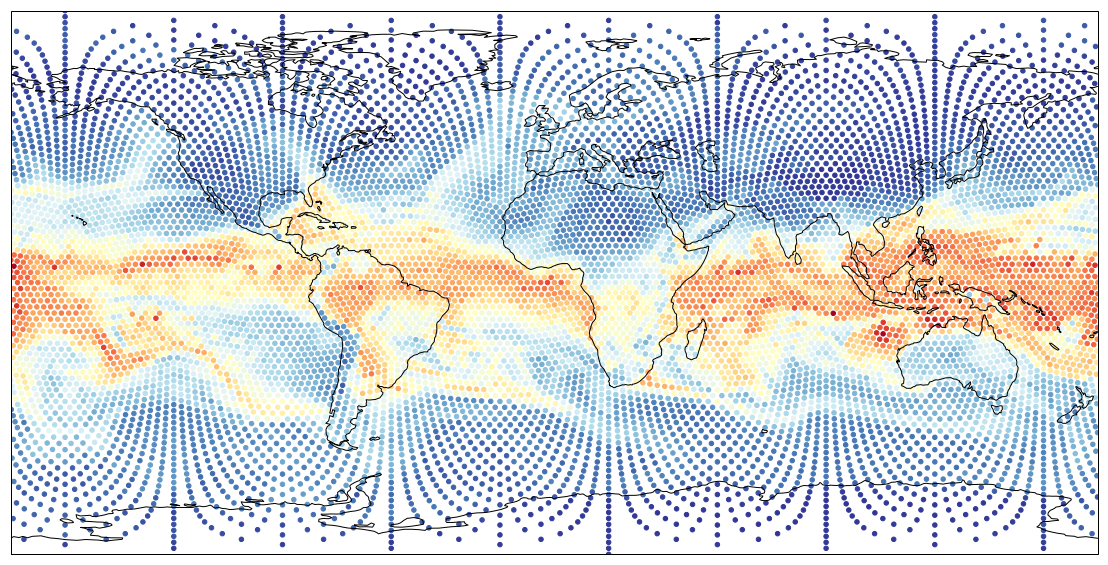

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(icolong, icolat, s=20,
            c=data[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

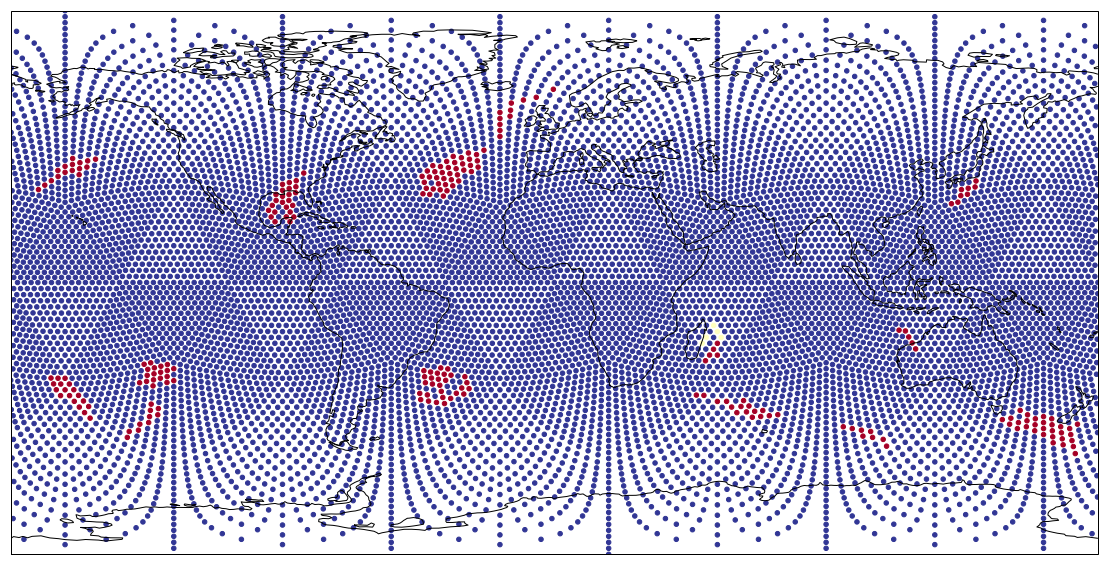

In [24]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(icolong, icolat, s=20,
            c=labels[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [83]:
from scipy.interpolate import griddata, RectBivariateSpline, RegularGridInterpolator, LinearNDInterpolator, interp2d, NearestNDInterpolator

In [134]:
from scipy.interpolate import griddata#, RectBivariateSpline, RegularGridInterpolator
Nside = 32
pix = np.arange(12*Nside**2)
coords_hp = hp.pix2ang(Nside, pix, nest=True, lonlat=True)
coords_hp = np.asarray(coords_hp).T
# lon_rad, lat_rad = np.deg2rad(lon), np.deg2rad(lat)
coords_map = hp.ang2vec(lon, lat, lonlat=True).reshape((-1, 3))
coords_map = np.stack([lon, lat], axis=-1).reshape((-1, 2))
# map_hp = griddata(coords_map, images[0,0].flatten(), coords_hp, 'linear')

In [22]:
t = time.time()
map_hp1 = griddata(coords_map, data[0].flatten(), coords_hp, 'linear')
print("time taken:", time.time()-t)

t = time.time()
f = RegularGridInterpolator((lon_, lat_), data[0].T)
map_hp3 = f(coords_hp)
print("time taken:", time.time()-t)

time taken: 22.371877908706665
time taken: 0.011130094528198242


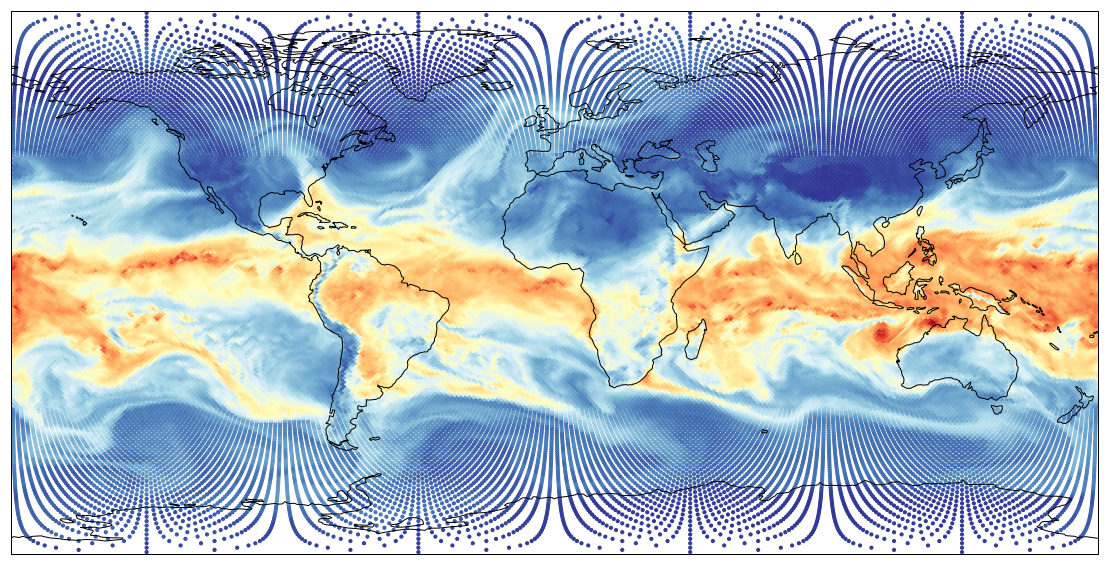

In [23]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=map_hp3, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [93]:
coords_map.shape

(884736, 2)

In [94]:
f = NearestNDInterpolator(coords_map, labels[:].flatten(), rescale=False)
new_labels = f(coords_hp)

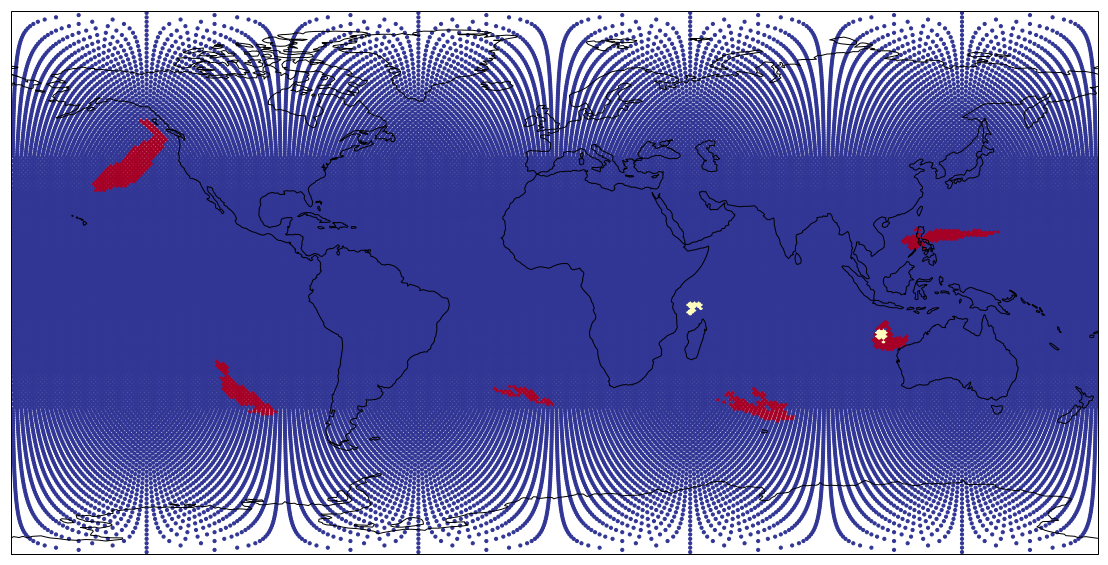

In [95]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=new_labels, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

## data

In [74]:
from glob import glob
year = 2106
path = '../../data/Climate/data-{}-01*.h5'.format(year)
files = glob(path)
datas = np.zeros((len(files),16,768,1152))
labels = np.zeros((len(files),768,1152))
for i, file in enumerate(files):
#     _, _, month, day, hour, run = file.split('-')
#     month, day, hour, run = int(month), int(day), int(hour), int(run[0])
    data = h5py.File(file)
    datas[i] = data['climate']['data']
    labels[i] = data['climate']['labels']

In [16]:
from glob import glob
year = 2106
path = '../../data/Climate/data_5_all/data-{}-*.npz'.format(year)
files = glob(path)
datas = np.zeros((len(files),16,10242))
labels = np.zeros((len(files),3,10242))
for i, file in enumerate(files):
#     _, _, month, day, hour, run = file.split('-')
#     month, day, hour, run = int(month), int(day), int(hour), int(run[0])
    data = np.load(file)
    datas[i] = data['data']
    labels[i] = data['labels']
#     datas.append(data)
#     labels.append(label)
# datas = np.stack(datas)
# labels = np.stack(labels)
labels = np.argmax(labels, axis=1)
datas = np.transpose(datas, axes=(0,2,1))

In [17]:
limit=6000
x_train = datas[:limit,:,:]
labels_train = labels[:limit,:]
x_val = datas[limit:,:,:]
labels_val = labels[limit:,:]

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

Jiang separation

In [9]:
precomp_mean = [26.160023, 0.98314494, 0.116573125, -0.45998842, 0.1930554, 0.010749293, 98356.03, 100982.02, 216.13145, 258.9456, 3.765611e-08, 288.82578, 288.03925, 342.4827, 12031.449, 63.435772]
precomp_std =  [17.04294, 8.164175, 5.6868863, 6.4967732, 5.4465833, 0.006383436, 7778.5957, 3846.1863, 9.791707, 14.35133, 1.8771327e-07, 19.866386, 19.094095, 624.22406, 679.5602, 4.2283397]


In [10]:
data = {}
for partition in ['test']:
    with open(path+partition+".txt", "r") as f:
        lines = f.readlines()
    flist = [os.path.join(path, 'data_5_all', l.replace('\n', '')) for l in lines]
    data[partition] = {'data': np.zeros((len(flist),10242,16)),
                       'labels': np.zeros((len(flist),10242))}
    for i, f in enumerate(flist):
        file = np.load(f)
        data[partition]['data'][i] = (file['data'].T - precomp_mean) / precomp_std
        data[partition]['labels'][i] = np.argmax(file['labels'].astype(np.int), axis=0)

In [ ]:
x_train = data['train']['data']
labels_train = data['train']['labels']

In [11]:
x_test = data['test']['data']
labels_test = data['test']['labels']

In [ ]:
training = LabeledDataset(data['train']['data'], data['train']['labels'])
validation = LabeledDataset(data['val']['data'], data['val']['labels'])
# test = LabeledDataset(data['test']['data'], data['test']['labels'])

In [12]:
del data

## Training

In [85]:
EXP_NAME = 'TestClimate_pooling_weight'

In [113]:
nside=32

In [122]:
import tensorflow as tf
params = {'nsides': [nside, nside,nside//2,nside//4,nside//8,nside//16,nside//32, nside//32],
          'F': [20, 20, 50, 80, 100, 200, 400],#np.max(labels_train).astype(int)+1],
          'K': [4]*7,
          'batch_norm': [True]*7}
params['dir_name'] = EXP_NAME
params['num_feat_in'] = x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'average'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 1000  # Number of passes through the training data.
params['batch_size'] = 8
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 10
params['eval_frequency'] = int(params['num_epochs'] * (training.N) / params['batch_size'] / n_evaluations)
params['M'] = []
params['Fseg'] = np.max(labels_train).astype(int)+1
params['dense'] = True

In [87]:
import tensorflow as tf
params = {'nsides': [5, 5, 4, 3, 2, 1, 0, 0],
          'F': [32, 64, 128, 256, 512, 512, 512],#np.max(labels_train).astype(int)+1],
          'K': [4]*7,
          'batch_norm': [True]*7}
params['sampling'] = 'icosahedron'
params['dir_name'] = EXP_NAME
params['num_feat_in'] = 16 # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'average'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 100  # Number of passes through the training data.
params['batch_size'] = 32
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 200
params['eval_frequency'] = int(params['num_epochs'] * (10000) / params['batch_size'] / n_evaluations)
params['M'] = []
params['Fseg'] = 3
params['dense'] = True

In [15]:
import tensorflow as tf
params = {'nsides': [5, 5, 5, 5],
          'F': [64, 128, 256],#np.max(labels_train).astype(int)+1],
          'K': [4]*3,
          'batch_norm': [True]*3}
params['sampling'] = 'icosahedron'
params['dir_name'] = EXP_NAME
params['num_feat_in'] = 16 # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'average'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 100  # Number of passes through the training data.
params['batch_size'] = 16
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-2, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 200
params['eval_frequency'] = int(params['num_epochs'] * (1000) / params['batch_size'] / n_evaluations)
params['M'] = []
params['Fseg'] = 3
params['dense'] = True

In [88]:
# print([12*nside**2 for nside in params['nsides']])
model = models.deepsphere(**params)

NN architecture
  input: M_0 = 10242
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 10242 * 32 / 10242 = 32
    weights: F_0 * F_1 * K_1 = 16 * 32 * 4 = 2048
    biases: F_1 = 32
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 10242 * 64 / 2562 = 255
    weights: F_1 * F_2 * K_2 = 32 * 64 * 4 = 8192
    biases: F_2 = 64
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 2562 * 128 / 642 = 510
    weights: F_2 * F_3 * K_3 = 64 * 128 * 4 = 32768
    biases: F_3 = 128
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 642 * 256 / 162 = 1014
    weights: F_3 * F_4 * K_4 = 128 * 256 * 4 = 131072
    biases: F_4 = 256
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 162 * 512 / 42 = 1974
    weights: F_4 * F_5 * K_5 = 256 * 512 * 4 = 524288
    biases: F_5 = 512
    batch normalization
  layer 6: cgconv6
    representation: M_5 * F_6 / p_6 = 42 * 512 / 12 = 1

In [ ]:
model.fit(training, validation)

In [28]:
x_train.shape

(43916, 10242, 16)

In [163]:
predictions2 = model.predict(x_test)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/TestClimate_pooling_weight/model-35672


In [164]:
probabilities2 = model.probs(x_test, 3)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/TestClimate_pooling_weight/model-35672


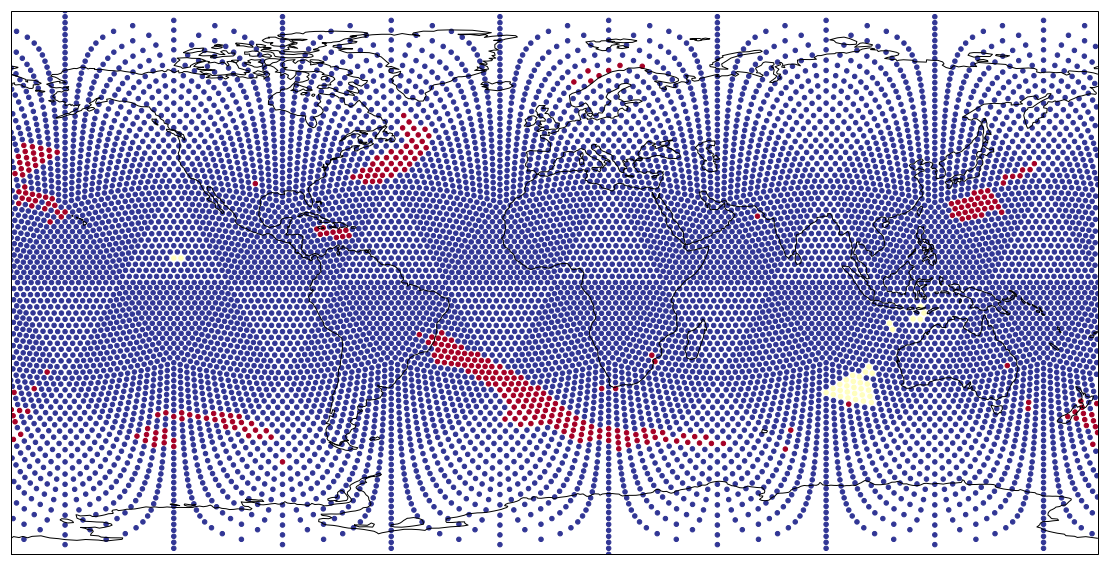

In [165]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(icolong, icolat, s=20,
            c=predictions2[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

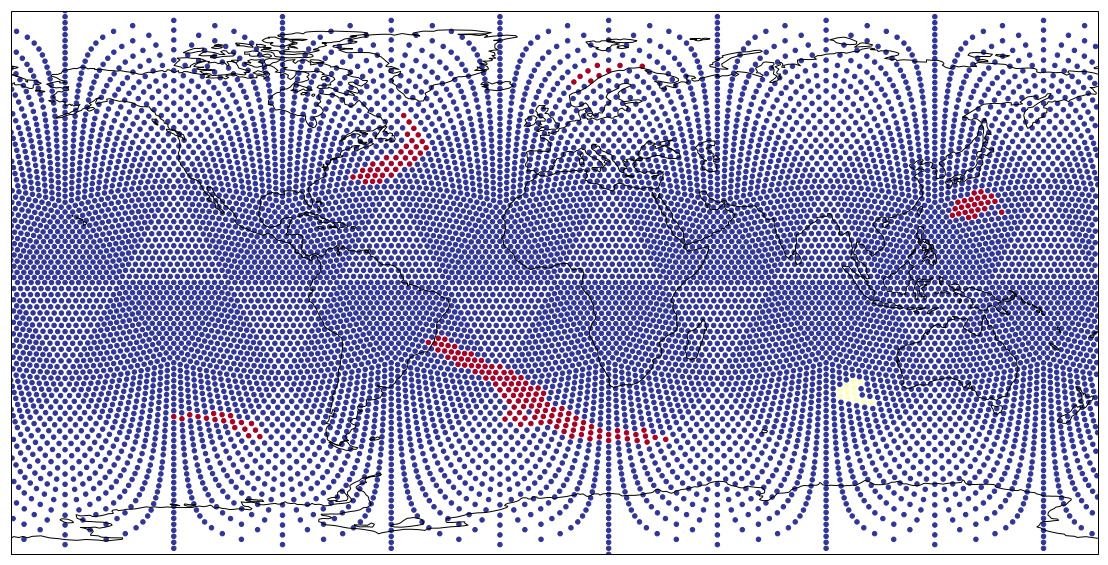

In [36]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(icolong, icolat, s=20,
            c=labels_test[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

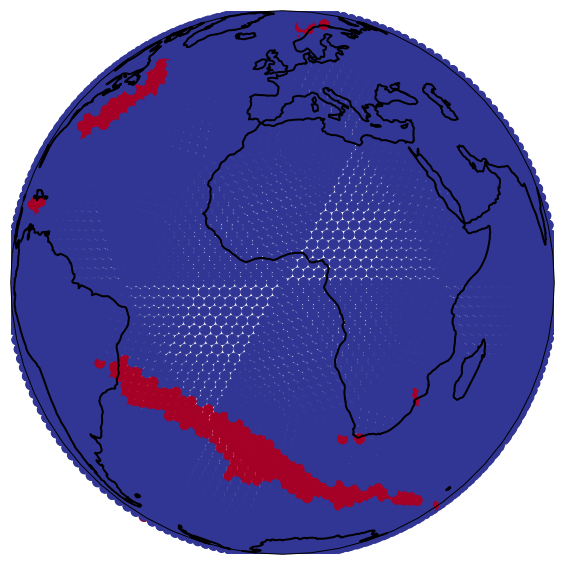

In [166]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 0))
ax.set_global()
ax.coastlines(linewidth=2)

# zmin, zmax = -20, 40

plt.scatter(icolong, icolat, s=100,
            c=predictions2[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1, transform=ccrs.PlateCarree())

In [22]:
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.preprocessing import label_binarize

In [23]:
def accuracy(pred_cls, true_cls, nclass=3):
    accu = []
    tot_int = 0
    tot_cl = 0
    for i in range(3):
        intersect = np.sum(((pred_cls == i) * (true_cls == i)))
        thiscls = np.sum(true_cls == i)
        accu.append(intersect / thiscls * 100)
        tot_int += intersect
        tot_cl += thiscls
    return np.array(accu), tot_int/tot_cl * 100

In [248]:
def average_precision(score_cls, true_cls, nclass=3):
    score = score_cls
    true = label_binarize(true_cls.reshape(-1), classes=[0, 1, 2])
    score = score.reshape(-1, nclass)
    return average_precision_score(true, score, 'macro')

In [249]:
average_precision(probabilities, labels_test)

0.8360974330667245

In [242]:
accuracy(predictions, labels_test)

(array([97.91256574, 95.96994942, 97.94814738]), 97.91132689021318)

In [168]:
average_precision(probabilities2, labels_test)

0.8379394972547725

In [247]:
np.mean([97.91256574, 95.96994942, 97.94814738])

97.27688751333335

In [40]:
from sklearn.utils.class_weight import compute_class_weight

In [41]:
compute_class_weight('balanced', [0,1,2], labels_train.flatten())

array([  0.34130685, 318.47388343,  14.93759951])

In [169]:
from sklearn.metrics import confusion_matrix

In [173]:
conf_mat = confusion_matrix(labels_test.reshape(-1), predictions.reshape(-1))

In [178]:
conf_mat

array([[122896781,    576494,   2043588],
       [     2278,    129022,      3140],
       [    15617,     43175,   2806521]])

In [180]:
nclass = [(labels_test==i).sum() for i in range(3)]

In [181]:
nclass

[125516863, 134440, 2865313]

In [217]:
(conf_mat.T/np.array(nclass)).T

array([[0.97912566, 0.00459296, 0.01628138],
       [0.01694436, 0.95969949, 0.02335614],
       [0.00545036, 0.01506816, 0.97948147]])

In [286]:
from matplotlib.colors import LogNorm, PowerNorm

In [280]:
conf_mat/np.sum(nclass)*100

array([[9.56271530e+01, 4.48575459e-01, 1.59013524e+00],
       [1.77253344e-03, 1.00393244e-01, 2.44326383e-03],
       [1.21517361e-02, 3.35948777e-02, 2.18378066e+00]])

In [291]:
np.log(conf_mat)

array([[18.62685538, 13.26472021, 14.53021764],
       [ 7.73105314, 11.76773821,  8.05197808],
       [ 9.65611534, 10.6730169 , 14.8474562 ]])

Text(0.5,0,'predictions')

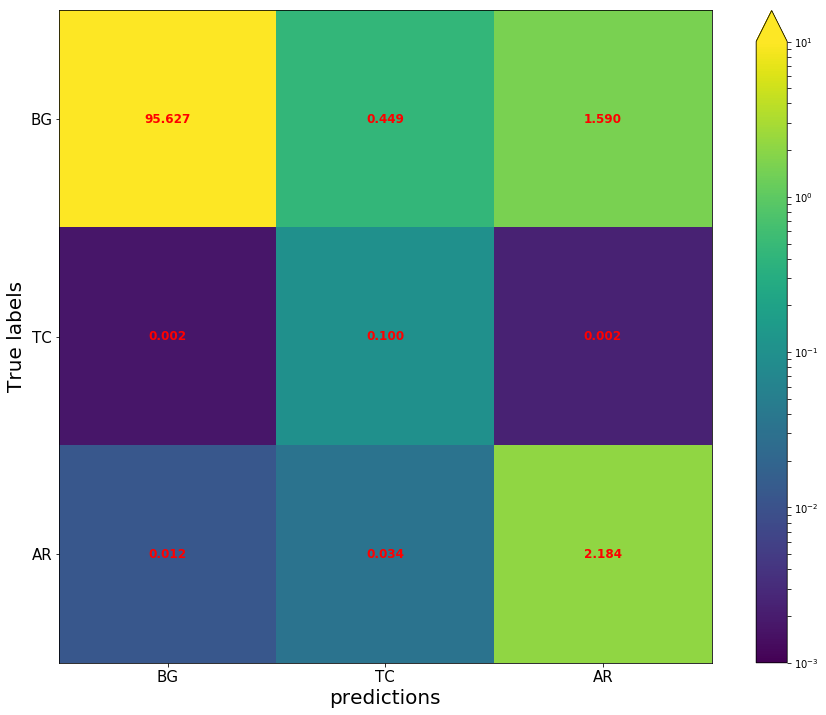

In [306]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow((conf_mat/np.sum(nclass))*100, norm=LogNorm(vmin=1e-3, vmax=1e1))#, cmap='RdYlBu')
fig.colorbar(im, ax=ax, extend='max')
for (j,i),label in np.ndenumerate(conf_mat/np.sum(nclass)*100):
    ax.text(i,j,"{:.3f}".format(label),ha='center',va='center', color='red', fontsize=12, fontweight='semibold')
#     ax2.text(i,j,label,ha='center',va='center')
plt.xticks([0,1,2], ['BG', 'TC', 'AR'], fontsize=15)
plt.yticks([0,1,2], ['BG', 'TC', 'AR'], fontsize=15)

plt.ylabel('True labels', fontsize=20)
plt.xlabel('predictions', fontsize=20)

In [220]:
from sklearn.metrics import precision_recall_curve

In [226]:
probabilities.reshape(-1,3)[:,1:3].sum(axis=-1)

array([3.39972605e-07, 2.53593429e-06, 7.50348171e-05, ...,
       9.99999938e-01, 9.99962937e-01, 9.99816493e-01])

In [228]:
prob0 = np.stack([probabilities.reshape(-1,3)[:,0], probabilities.reshape(-1,3)[:,1:3].sum(axis=-1)])

In [231]:
precision, recall, thresholds = precision_recall_curve(labels_test.reshape(-1)==0, probabilities.reshape(-1,3)[:,0])

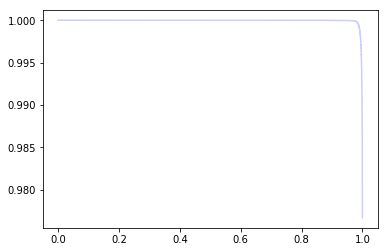

In [232]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

In [233]:
precision, recall, thresholds = precision_recall_curve(labels_test.reshape(-1)==1, probabilities.reshape(-1,3)[:,1])

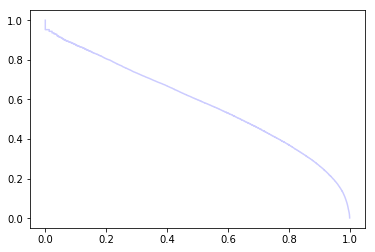

In [234]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

In [235]:
precision, recall, thresholds = precision_recall_curve(labels_test.reshape(-1)==2, probabilities.reshape(-1,3)[:,2])

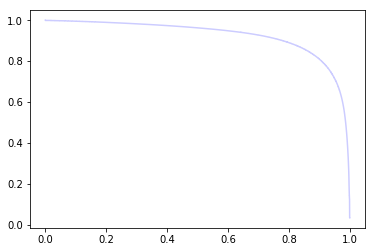

In [236]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

In [255]:
from sklearn.metrics import roc_auc_score, roc_curve

In [256]:
auc = roc_auc_score(label_binarize(labels_test.reshape(-1), classes=[0, 1, 2]), probabilities.reshape(-1,3), None)

In [258]:
auc

array([0.99777066, 0.99882186, 0.99777455])

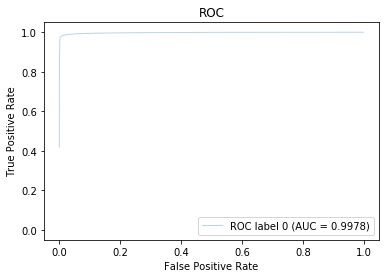

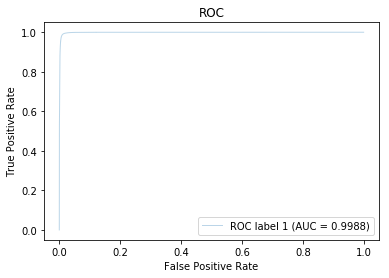

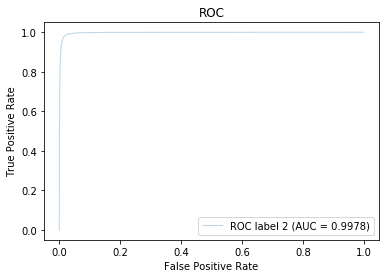

In [259]:
for i in range(3):
    fpr, tpr, thr = roc_curve(labels_test.reshape(-1)==i, probabilities.reshape(-1,3)[:,i])
    plt.figure()
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC label %d (AUC = %0.4f)' % (i, auc[i]))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")